# Dataset preparation

Firstly we need to load the dataset in, unzip it and split data into training and testing. It consists of these steps:

  - Mounting google drive, so colab can access it
  - Copying the data from gdrive and unzipping them
  - Loading the data and splitting them into training and testing

The gdrive part is done, because I have downloaded the dataset archive to my personal google drive.

### Mounting gdrive to colab

In [1]:
# mounting google drive with dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Unzipping data from gdrive

In [2]:
import shutil
import zipfile

# defining path to save dataset to in colab
zipPath = '/content/drive/MyDrive/DatasetySOC/archive.zip'

# unzipping dataset
with zipfile.ZipFile(zipPath, 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')

### Creating new directories we will use for our dataset

Here comes the first problem. The images and masks are in the same folder, so we need to firstly split them. Then we need to load them into both training and testing folders, for better manipulation and future work with the dataset.

In [3]:
import os

# defining paths
dataDir = '/content/dataset/PV03/PV03_Ground_Cropland'
trainImagesDir = '/content/dataset/training/images'
trainMasksDir = '/content/dataset/training/masks'
testImagesDir = '/content/dataset/testing/images'
testMasksDir = '/content/dataset/testing/masks'
valImagesDir = '/content/dataset/validation/images'
valMasksDir = '/content/dataset/validation/masks'

# create new directories
os.makedirs(trainImagesDir, exist_ok=True)
os.makedirs(trainMasksDir, exist_ok=True)
os.makedirs(testImagesDir, exist_ok=True)
os.makedirs(testMasksDir, exist_ok=True)
os.makedirs(valImagesDir, exist_ok=True)
os.makedirs(valMasksDir, exist_ok=True)

Note: I am using only one of many of folders from the dataset. This dataset contains images with background type Ground_Cropland. I figured out, it would be perfect for my task. In the future, more folders should be used and be trained on to ensure the model accuracy.

### Sorting the data

In [4]:
# lists all files in data directory
allFiles = os.listdir(dataDir)

# separate image files from masks
images = [f for f in allFiles if not f.endswith('label.bmp') and f.endswith('.bmp')]
masks = [f for f in allFiles if f.endswith('label.bmp')]

# sort, so each mask corresponds to an image
images.sort()
masks.sort()


# test print to see if everything works as intended
print("SAMPLE IMAGE:", images[0])
print("SAMPLE MASK: ", masks[0])

SAMPLE IMAGE: PV03_314875_1196456.bmp
SAMPLE MASK:  PV03_314875_1196456_label.bmp


### Splitting data into training, validation and testing

In [5]:
from sklearn.model_selection import train_test_split

# split image data into training and validation in 80:20 ratio
trainImages, valImages, trainMasks, valMasks = train_test_split(images, masks, test_size=0.2, random_state=1)

# then split train data into training and testing in 88:12 ratio (testing will be circa 10 % of dataset)
trainImages, testImages, trainMasks, testMasks = train_test_split(trainImages, trainMasks, test_size=0.12, random_state=1)


# set images into their directories
for img in trainImages:
  shutil.copy(os.path.join(dataDir, img), trainImagesDir) # moves image to train folder
for img in valImages:
  shutil.copy(os.path.join(dataDir, img), valImagesDir) # moves image to validation folder
for img in testImages:
  shutil.copy(os.path.join(dataDir, img), testImagesDir) # moves image to test folder


# set masks into their directories
for img in trainMasks:
  shutil.copy(os.path.join(dataDir, img), trainMasksDir) # moves mask to train folder
for img in valMasks:
  shutil.copy(os.path.join(dataDir, img), valMasksDir) # moves mask to validation folder
for img in testMasks:
  shutil.copy(os.path.join(dataDir, img), testMasksDir) # moves mask to test folder


# control print
print("Data split into training, validation and testing")

Data split into training, validation and testing


# Dataset preprocessing

The dataset we just prepared isn't exactly what we will be feeding our model. First we need to turn the data into a format that the model will understand and can use. This consists of these steps:

  - preprocessing data
  - turning data into arrays


### Cropping images and masks to size 512x512

I am using an example model from the book Deep learning in python by François Chollet. In this example, the images that the model is taught on are the size of 200x200. Our images are the size of 1024x1024, so we need to crop them, simply downscaling them would mean losing important detail. By cropping, we also create more data for the model to train on.

In [6]:
import cv2
from tqdm import tqdm # just to display progress bar

# define new directories to save crops to
cropped_trainImagesDir = '/content/dataset/training/croppedImages'
cropped_trainMasksDir = '/content/dataset/training/croppedMasks'
cropped_valImagesDir = '/content/dataset/validation/croppedImages'
cropped_valMasksDir = '/content/dataset/validation/croppedMasks'
cropped_testImagesDir = '/content/dataset/testing/croppedImages'
cropped_testMasksDir = '/content/dataset/testing/croppedMasks'

# create directories for cropped images and masks
os.makedirs(cropped_trainImagesDir, exist_ok=True)
os.makedirs(cropped_trainMasksDir, exist_ok=True)
os.makedirs(cropped_valImagesDir, exist_ok=True)
os.makedirs(cropped_valMasksDir, exist_ok=True)
os.makedirs(cropped_testImagesDir, exist_ok=True)
os.makedirs(cropped_testMasksDir, exist_ok=True)


# cropping images to size 512x512
def crop_and_save(image, mask, img_name, mask_name, output_img_dir, output_mask_dir, crop_size=(512, 512)):
    h, w = image.shape[:2]        # shape of an array is the number of elements in each dimension
    crop_h, crop_w = crop_size

    # define the four crops - top-left, top-right, bottom-left, bottom-right
    crops_coords = [
        (0, 0, crop_h, crop_w),  # top-left
        (0, w - crop_w, crop_h, w),  # top-right
        (h - crop_h, 0, h, crop_w),  # bottom-left
        (h - crop_h, w - crop_w, h, w)  # bottom-right
    ]

    # crop image to four parts
    for i, (y1, x1, y2, x2) in enumerate(crops_coords):
        cropped_image = image[y1:y2, x1:x2]
        cropped_mask = mask[y1:y2, x1:x2]

        # save cropped images and masks
        new_img_name = f"{os.path.splitext(img_name)[0]}_crop_{i}.bmp"
        new_mask_name = f"{os.path.splitext(mask_name)[0]}_crop_{i}.bmp"
        cv2.imwrite(os.path.join(output_img_dir, new_img_name), cropped_image)
        cv2.imwrite(os.path.join(output_mask_dir, new_mask_name), cropped_mask)

# function to crop images and masks and put them to their corresponding directories
def process_and_crop_images(images_dir, masks_dir, output_img_dir, output_mask_dir):
    images = sorted(os.listdir(images_dir)) # don't need to sort it here, I am sorting it before
    masks = sorted(os.listdir(masks_dir))

    # ensure images and masks match
    if len(images) != len(masks):
        print("Error: The number of images and masks do not match.")
        return

    # save crops
    for img_name, mask_name in tqdm(zip(images, masks), total=len(images)):
        img_path = os.path.join(images_dir, img_name)
        mask_path = os.path.join(masks_dir, mask_name)

        # load images and masks
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, 0)  # grayscale mask

        # check if both image and mask are loaded
        if image is None or mask is None:
            print(f"Error loading {img_name} or {mask_name}")
            continue

        # apply cropping and save
        crop_and_save(image, mask, img_name, mask_name, output_img_dir, output_mask_dir)

# crop training images and masks
process_and_crop_images(trainImagesDir, trainMasksDir, cropped_trainImagesDir, cropped_trainMasksDir)

# crop validation data
process_and_crop_images(valImagesDir, valMasksDir, cropped_valImagesDir, cropped_valMasksDir)

# crop testing images and masks
process_and_crop_images(testImagesDir, testMasksDir, cropped_testImagesDir, cropped_testMasksDir)

print("\nCropping done...")

100%|██████████| 83/83 [00:04<00:00, 18.14it/s]


Cropping done...


NOTE: I could crop the images to size 256x256 and then downscale them, more detail would be preserved using this approach. But unfortunately, if I create more data then I have by using the method I am using, colab would run out of RAM and crash. If using more advanced technology, I suggest making the crops more similiar to the wanted size for the model.

### Transform images into arrays

The model takes image data as an array, so we need to firstly resize those images and then turn them into arrays. The mask normalization is also done in this part, so the model predictions and original mask values match.

In [7]:
import os
import numpy as np
import random
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
import matplotlib.pyplot as plt


# defining image size (for model training)
img_size = (200, 200)

# function to load images and resize
def load_image(path):
    return img_to_array(load_img(path, target_size=img_size))   # img_to_array is a part of the tensorflow library, load_img also

# function to load masks and preprocess
def load_mask(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8")  # setting data type to uint8

    # map mask values to different values (so it is the same as in the example from book)
    img[img == 0] = 0
    img[img == 123] = 1
    img[img == 255] = 2

    return img

# sort and load training data into array
train_image_paths = sorted([os.path.join(cropped_trainImagesDir, fname) for fname in os.listdir(cropped_trainImagesDir)])
train_mask_paths = sorted([os.path.join(cropped_trainMasksDir, fname) for fname in os.listdir(cropped_trainMasksDir)])

train_input_imgs = np.array([load_image(img_path) for img_path in train_image_paths])
train_targets = np.array([load_mask(mask_path) for mask_path in train_mask_paths])

# sort and load validation data into array
val_image_paths = sorted([os.path.join(cropped_valImagesDir, fname) for fname in os.listdir(cropped_valImagesDir)])
val_mask_paths = sorted([os.path.join(cropped_valMasksDir, fname) for fname in os.listdir(cropped_valMasksDir)])

val_input_imgs = np.array([load_image(img_path) for img_path in val_image_paths])
val_targets = np.array([load_mask(mask_path) for mask_path in val_mask_paths])

# sort and load testing data into array
test_image_paths = sorted([os.path.join(cropped_testImagesDir, fname) for fname in os.listdir(cropped_testImagesDir)])
test_mask_paths = sorted([os.path.join(cropped_testMasksDir, fname) for fname in os.listdir(cropped_testMasksDir)])

test_input_imgs = np.array([load_image(img_path) for img_path in test_image_paths])
test_targets = np.array([load_mask(mask_path) for mask_path in test_mask_paths])


# The model

Now we need to fit the model with our data and evaluate the results. We will achieve it in these steps:

  - Define the model
  - Compile and fit the model
  

### Defining and compiling model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# define the model
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,)) # input layer

    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)  # output layer
    return keras.Model(inputs, outputs)

model = get_model(img_size=img_size, num_classes=3)

# review model
model.summary()

# compile model
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 50, 50, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 100, 100, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 100, 100, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 200, 200, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 200, 200, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

### Fitting the model

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - loss: 0.8708 - val_loss: 0.6241
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 55s 574ms/step - loss: 0.6215 - val_loss: 0.6123
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 554ms/step - loss: 0.6163 - val_loss: 0.6115
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 571ms/step - loss: 0.5380 - val_loss: 0.3627
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 559ms/step - loss: 0.3885 - val_loss: 0.2295
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 579ms/step - loss: 0.3448 - val_loss: 0.2199
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 548ms/step - loss: 0.2457 - val_loss: 0.1440
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 541ms/step - loss: 0.1753 - val_loss: 0.1479
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 565ms/step - loss: 0.1750 - val_loss: 0.1193
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 551ms/step - loss: 0.1855 - val_loss: 0.1159
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 573ms/step - loss: 0.1438 - val_loss: 0.1027
Epoch 12/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 

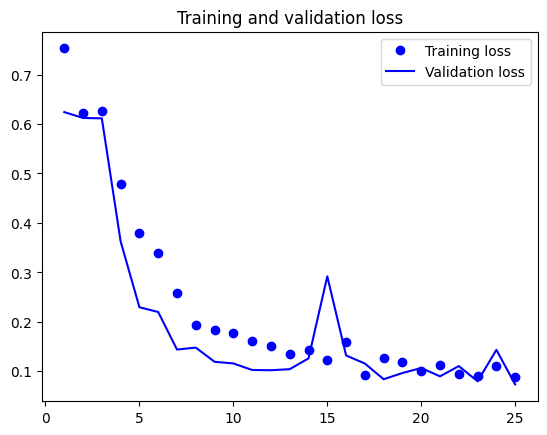

In [ ]:
# set model name
modelName = "bestKerasModel.keras"

# callbacks to save only best model
callbacks = [
    keras.callbacks.ModelCheckpoint(modelName, save_best_only=True)
]

# fit (train) the model
history = model.fit(train_input_imgs, train_targets, epochs=25, batch_size=64,
                    validation_data=(val_input_imgs, val_targets), callbacks=callbacks)

# display loss graph
epochs = range(1, len(history.history["loss"]) + 1)
plt.plot(epochs, history.history["loss"], "bo", label="Training loss")
plt.plot(epochs, history.history["val_loss"], "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Model evaluation

Here we will evaluate the model results and see, how well the mask prediction works.

### Display true and predicted mask

Model loaded successfully.


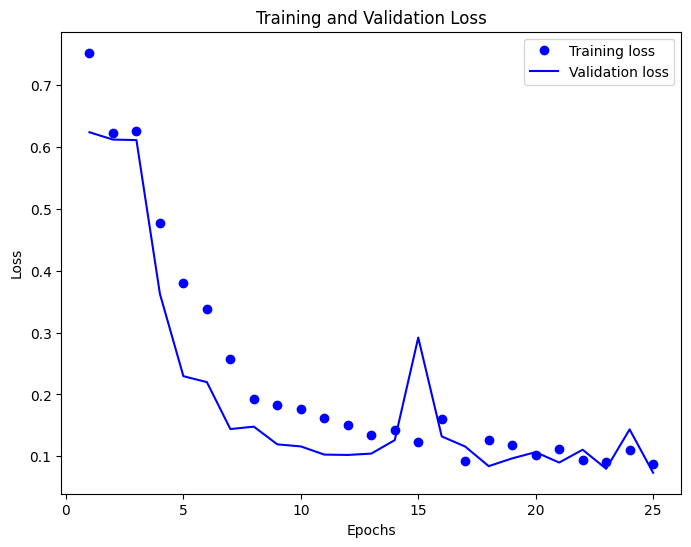

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


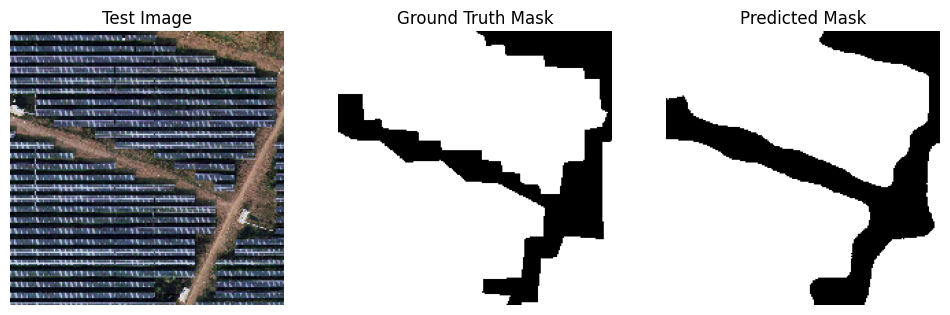

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.models import load_model



# function to evaluate the model performance
def evaluate_model(model_path, history, test_image_idx, test_images, test_masks):

    # load saved model
    model = load_model(model_path)
    print("Model loaded successfully.")

    # display loss curve, if the history was saved too
    if history:
        epochs = range(1, len(history["loss"]) + 1)
        plt.figure(figsize=(8, 6))
        plt.plot(epochs, history["loss"], "bo", label="Training loss")
        plt.plot(epochs, history["val_loss"], "b", label="Validation loss")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    # display test image
    if test_images is not None:
        test_image = test_images[test_image_idx]
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.title("Test Image")
        plt.imshow(array_to_img(test_image))

        # show corresponding mask
        if test_masks is not None:
            plt.subplot(1, 3, 2)
            plt.axis("off")
            plt.title("Ground Truth Mask")
            mask = test_masks[test_image_idx]
            plt.imshow(mask[:, :, 0], cmap="gray")

        # show prediction
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.title("Predicted Mask")
        predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]
        pred_mask = np.argmax(predicted_mask, axis=-1)
        plt.imshow(pred_mask, cmap="gray")
        plt.show()

    else:
        print("Test images not provided. Cannot display predictions.")


#modelName = "segmentationExampleImgProcessing.keras"

# WRITE PARAMETERS FOR THE FUNCTION HERE
model_path = modelName # saved model
history_data = history.history  # model history
test_images = test_input_imgs  # test images array
test_masks = test_targets      # test masks array

# calling the evaluation function
evaluate_model(
    model_path=model_path,
    history=history_data,
    test_image_idx=0,  # index of image from the array
    test_images=test_images,
    test_masks=test_masks
)


The loss curve displays how well the model trained in each epoch

Below it we can see the original downscaled image, the original mask and finally the predicted mask

### Masking the background off the image

Now we can visually display the model output on testing data and see, how well the model works on data, that were not in the part of model's training arc.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


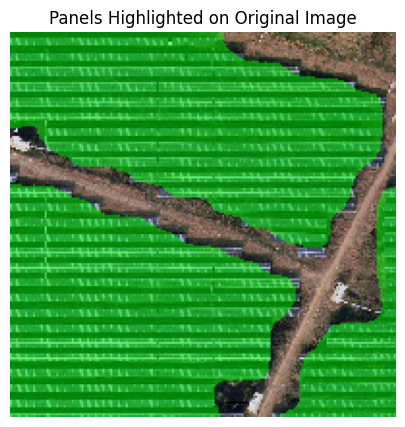

'\n# save newly created image\nimgPath = "panelsAreaHighlighted.png"\nimg_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)   # Converts bgr image to rgb (openCV uses BGR images for some reason)\ncv2.imwrite(imgPath, img_rgb) # note: file needs to be png for the alpha channel to work\n'

In [ ]:
from tensorflow.keras.models import load_model

# load and save test image
testImage = test_input_imgs[0]
cv2.imwrite("testImage.bmp", testImage)

# load the model
model = load_model("/content/bestKerasModel.keras")

# predict the mask of the image
predictedMask = model.predict(np.expand_dims(testImage, axis=0))[0]
predictedMask = np.argmax(predictedMask, axis=-1)

'''
# Ensure the mask dimensions match the image dimensions
if predictedMask.shape[:2] != testImage.shape[:2]:
    predictedMask = cv2.resize(predictedMask, (testImage.shape[1], testImage.shape[0]), interpolation=cv2.INTER_NEAREST)
'''

# Create a copy of the original image to modify
output_image = testImage.copy()

# Highlight the panel areas by applying the mask
highlight_color = [0, 255, 0]  # Green color for highlighting
output_image[predictedMask > 0] = (
    0.5 * output_image[predictedMask > 0] + 0.5 * np.array(highlight_color)
).astype(np.uint8)

# Display the result
plt.figure(figsize=(10, 5))
plt.title("Panels Highlighted on Original Image")
plt.imshow(output_image.astype('uint8'))
plt.axis("off")
plt.show()

'''
# save newly created image
imgPath = "panelsAreaHighlighted.png"
img_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)   # Converts bgr image to rgb (openCV uses BGR images for some reason)
cv2.imwrite(imgPath, img_rgb) # note: file needs to be png for the alpha channel to work
'''

This masks out the background completely, so only the panels are displayed and the rest of the image will be transparent

In [ ]:
'''
# getting the image in form of numpy array
testImage = test_input_imgs[0]
cv2.imwrite("testImage.bmp", testImage)


# load model
model = load_model("/content/bestKerasModel.keras")

# predict the mask of the image
predictedMask = model.predict(np.expand_dims(testImage, axis=0))[0]
predictedMask = np.argmax(predictedMask, axis=-1)

# mask out the background
img = np.zeros_like(testImage)  # array of zeroes with same shape as image
img[predictedMask > 0] = testImage[predictedMask > 0]   # use only pixels from mask


# display final image
plt.figure(figsize=(10, 5))
plt.title("Image with Transparent Background")
plt.imshow(img.astype('uint8'))  # Display RGBA image
plt.axis("off")
plt.show()



# save newly created image
imgPath = "imageWithoutBackground.png"
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Converts bgr image to rgb (openCV uses BGR images for some reason)
cv2.imwrite(imgPath, img_rgb) # note: file needs to be png for the alpha channel to work
'''

'\n# getting the image in form of numpy array\ntestImage = test_input_imgs[0]\ncv2.imwrite("testImage.bmp", testImage)\n\n\n# load model\nmodel = load_model("/content/bestKerasModel.keras")\n\n# predict the mask of the image\npredictedMask = model.predict(np.expand_dims(testImage, axis=0))[0]\npredictedMask = np.argmax(predictedMask, axis=-1)\n\n# mask out the background\nimg = np.zeros_like(testImage)  # array of zeroes with same shape as image\nimg[predictedMask > 0] = testImage[predictedMask > 0]   # use only pixels from mask\n\n\n# display final image\nplt.figure(figsize=(10, 5))\nplt.title("Image with Transparent Background")\nplt.imshow(img.astype(\'uint8\'))  # Display RGBA image\nplt.axis("off")\nplt.show()\n\n\n\n# save newly created image\nimgPath = "imageWithoutBackground.png"\nimg_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Converts bgr image to rgb (openCV uses BGR images for some reason)\ncv2.imwrite(imgPath, img_rgb) # note: file needs to be png for the alpha channel 

### Calculate model accuracy

In [ ]:
from tensorflow.keras.models import load_model

# load model
model = load_model("/content/bestKerasModel.keras")

# function to calculate accuracy
def getAcc(predMask, trueMask):
  correctPixels = np.sum(predMask == trueMask)
  totalPixels = np.prod(trueMask.shape)
  return correctPixels/totalPixels

# initialize total accuracy variable
accuracy = 0

# cycle through whole test set
for i in range(len(test_input_imgs)):
  # make a prediction
  predMask = model.predict(np.expand_dims(test_input_imgs[i], axis=0), verbose = 0)[0]
  predMask = np.argmax(predMask, axis=-1) # predMask shape is (200, 200) after applying np.argmax()

  # load the true mask
  trueMask = test_targets[i]
  trueMask = np.argmax(trueMask, axis=-1) # true mask shape is (200, 200, 1), remove last channel using np.argmax()

  '''
  # DEBUG: check for shape
  if predMask.shape != trueMask.shape:
      raise ValueError(f"Shape mismatch: predicted mask shape {predMask.shape}, true mask shape {trueMask.shape}")
  '''

  # calculate the overal accuracy
  acc = getAcc(predMask, trueMask)
  accuracy += acc
  #print(f"Image {i}, accuracy + {acc}\n")

# print out average model accuracy
print(f"Model accuracy: {(accuracy/len(test_input_imgs)) * 100:.2f} %")

Model accuracy: 71.95 %


# Detect individual panels with image processing

We have managed to detect the mask of FV panels, but only as a group. In this next bit, let's try and detect individual panels one by one. This part will consist of:
- preprocessing the masks
- masking out original image
- detecting horizontal stripes where panels are
- detecting individual panels


### Predict, resize and join masks

Panel detection will be made on original data, so first we need to prepare a mask of original image size. This consists of resizing the masks and correctly joining them together.

In [40]:
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
import os

# get original image path
dirPath = "/content/dataset/testing/images" # WHEN WORKING WITH CROPPED VERSION, JUST CHANGE THIS PATH
imgPaths = sorted([os.path.join(dirPath, f) for f in os.listdir(dirPath)])  # dir for all file paths

# load image in original size as numpy array
imgId = 0
img = load_img(imgPaths[imgId])
img = img_to_array(img)


# produces full size mask
def processMask(img, imgId):
  # get all crops of one full test image (now they are size 200x200 for model predict)
  testImage1 = test_input_imgs[imgId*4]   # one full image is 4 consecutive crops from directory
  testImage2 = test_input_imgs[imgId*4+1]
  testImage3 = test_input_imgs[imgId*4+2]
  testImage4 = test_input_imgs[imgId*4+3]

  # define model for prediction
  model = load_model("/content/bestKerasModel.keras")

  # predicting the masks for each crop
  predictedMask1 = model.predict(np.expand_dims(testImage1, axis=0), verbose = 0)[0]
  predictedMask1 = np.argmax(predictedMask1, axis=-1).astype('float32') # NOTE: don't forget to convert type to float32 for cv2 operations to work
  predictedMask2 = model.predict(np.expand_dims(testImage2, axis=0), verbose = 0)[0]
  predictedMask2 = np.argmax(predictedMask2, axis=-1).astype('float32')
  predictedMask3 = model.predict(np.expand_dims(testImage3, axis=0), verbose = 0)[0]
  predictedMask3 = np.argmax(predictedMask3, axis=-1).astype('float32')
  predictedMask4 = model.predict(np.expand_dims(testImage4, axis=0), verbose = 0)[0]
  predictedMask4 = np.argmax(predictedMask4, axis=-1).astype('float32')

  # resize predicted masks to size of original crops (512x512)
  resizedMask1 = cv2.resize(predictedMask1, (512, 512), interpolation=cv2.INTER_LINEAR)
  resizedMask2 = cv2.resize(predictedMask2, (512, 512), interpolation=cv2.INTER_LINEAR)
  resizedMask3 = cv2.resize(predictedMask3, (512, 512), interpolation=cv2.INTER_LINEAR)
  resizedMask4 = cv2.resize(predictedMask4, (512, 512), interpolation=cv2.INTER_LINEAR)

  # stick crops together to get full size image (1024x1024)
  topRow = np.hstack((resizedMask1, resizedMask2))
  botRow = np.hstack((resizedMask3, resizedMask4))
  mask = np.vstack((topRow,botRow))

  return mask

# save mask as variable
# mask = processMask(img, imgId)


# cv2_imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

'''
# display original image
plt.figure(figsize=(20, 10))
plt.title("Original image")
plt.imshow(img.astype('uint8'))
plt.axis("off")
plt.show()

# display mask result
plt.figure(figsize=(15, 7))
plt.title("Masks joined")
plt.imshow(mask.astype('uint8'))
plt.axis("off")
plt.show()
'''

'\n# display original image\nplt.figure(figsize=(20, 10))\nplt.title("Original image")\nplt.imshow(img.astype(\'uint8\'))\nplt.axis("off")\nplt.show()\n\n# display mask result\nplt.figure(figsize=(15, 7))\nplt.title("Masks joined")\nplt.imshow(mask.astype(\'uint8\'))\nplt.axis("off")\nplt.show()\n'

POZNAMKA: Pri evaluaci uspesnosti pouzivat vyrezy, ke ztrate kvality zde nedochazi a preskoci se krok, kde musim spojit vsechny masky dohromady - actually nemusim, pac to neni zas tak vypocetne narocny

### DEBUG: Display the whole image with panel areas highlighted

In [41]:
'''
output_image = img.copy()

# Highlight the panel areas by applying the mask
highlight_color = [255, 0, 0]  # color for highlighting
output_image[mask > 0] = (
    0.5 * output_image[mask > 0] + 0.5 * np.array(highlight_color)
).astype(np.uint8)

# cv2_imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
'''

'\noutput_image = img.copy()\n\n# Highlight the panel areas by applying the mask\nhighlight_color = [255, 0, 0]  # color for highlighting\noutput_image[mask > 0] = (\n    0.5 * output_image[mask > 0] + 0.5 * np.array(highlight_color)\n).astype(np.uint8)\n\n# cv2_imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))\n'

### Mask out background off image

Masking out the image background before edge detection can lead to either positive or negative results. I recommend testing, which method is better. If the background contains important detail, mask it out at the end right before individual pannel detection.

In [42]:
# returns grayscale image without background
def maskBackground(img, mask):
  # mask out background, so the edge detection is applied only in the parts we want
  grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  maskedImg = np.zeros_like(grayImg)  # array of zeroes with same shape as image
  maskedImg[mask > 0] = grayImg[mask > 0]   # use only pixels from mask

  return maskedImg

# save masked image as variable
# maskedImg = maskBackground(img, processMask(img, imgId))

# cv2_imshow(maskedImg)

### Use edge detection on image

Now we need to prepare images, where there are edges highlighted. Later, we will make detections based on those edges.

In [43]:
from google.colab.patches import cv2_imshow

# detects horizontal edges
def horizontalEdges(src):
  # define sedond-derivation kernel for horizontal lines
  kernel = np.array([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]], dtype=np.float32)

  # detect horizontal lines using filter
  filteredImg = cv2.filter2D(src, cv2.CV_32F, kernel)
  _, thresh = cv2.threshold(filteredImg, 100, 255, cv2.THRESH_BINARY)
  edgesH = cv2.convertScaleAbs(thresh)

  # return detected edges
  return edgesH

# detects vertical edges
def verticalEdges(src):
  # define sedond-derivation kernel for horizontal lines
  kernel = np.array([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]], dtype=np.float32)

  # detect vertical lines using filter
  filteredImg2 = cv2.filter2D(src, cv2.CV_32F, kernel.transpose())  # transpose kernel to detect vertical lines
  _, thresh2 = cv2.threshold(filteredImg2, 100, 255, cv2.THRESH_BINARY)
  edgesV = cv2.convertScaleAbs(thresh2)

  # return detected edges
  return edgesV

# save edges as variable
#edgesH = horizontalEdges(maskedImg)
#edgesV = verticalEdges(maskedImg)


# show grayscale image and detected edges
#cv2_imshow(maskedImg)
#cv2_imshow(edgesH)
#cv2_imshow(edgesV)


### Detect horizontal stripes from lines

Firstly, we need to detect horizontal stripes. These stripes will be foreground (panels) or background.

In [44]:

def getHorizontalStripes(rgb, edgesH):
  #global stripes
  stripes = []  # array of stripes

  # hough transform for line detection
  lines = cv2.HoughLines(edgesH, rho=1, theta=np.pi / 4, threshold=100)
  #print(f"Number of detected lines on edgesH image: {len(lines)}")

  rhos = []
  # select only horizontal lines
  if lines is not None:
    for line in lines:
      rho, theta = line[0]

      # if theta is 0 degrees or 180 degrees +- 5 degrees, line is horizontal
      if abs(theta - np.pi/2) < np.pi / 36 or abs(theta + np.pi/2) < np.pi / 36:
        rhos.append(int(rho))
  rhos.sort()


  # generate stripes
  height, width = rgb.shape[:2]
  rho0 = -1
  for rho in rhos:
    if rho0 > -1:
      stripes.append((0, int(rho0), width, int(rho-rho0), -1))  # set stripe dimensions (x1, y1, width, height, class [used later])
    rho0 = rho

  return stripes
'''
stripes = getHorizontalStripes(img, edgesH)
rgb = img.copy()


# display detected horizontal lines
output = rgb.copy()
for stripe in stripes:
  cv2.rectangle(output, (stripe[0], stripe[1]), (stripe[0]+stripe[2], stripe[1]+stripe[3]), (255, 0, 0), 1) # (image, (x1, y1), (x2, y2), color, line thickness)
cv2_imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
'''
'''
plt.figure(figsize=(10, 5))
plt.title("Stripe detection")
plt.imshow(output.astype('uint8'))
plt.axis("off")
plt.show()
'''

'\nplt.figure(figsize=(10, 5))\nplt.title("Stripe detection")\nplt.imshow(output.astype(\'uint8\'))\nplt.axis("off")\nplt.show()\n'

### Stripe classification


The panels are all the same class, but we don't want that. Stripes will be classified as panels and background.

In [45]:
def classifyStripes(stripes, edgesV):
  # convert tuples in stripes to lists, so they can be modified
  stripes = [list(stripe) for stripe in stripes]

  for stripe in stripes:
    stripeVertical = edgesV[stripe[1]:stripe[1]+stripe[3], stripe[0]:stripe[0]+stripe[2]] # cutout is [y1:y2, x1:x2]

    # number of vertical lines in stripe in proportion to stripe size
    c = 1.0 * cv2.sumElems(stripeVertical)[0] / (int(stripe[2]) * int(stripe[3]))
    # panel
    if (c > 12) and (stripe[3] > 3): # also checking minimum stripe height
      stripe[4] = 0 # add fourth channel, containing info whether the stripe is panel or background
    # background
    else:
      stripe[4] = 1
    #print(stripe, c)

  # return stripes object
  return stripes

'''
classifiedStripes = classifyStripes(stripes, edgesV)


# visualize
output = rgb.copy()
for stripe in classifiedStripes:
  if stripe[4] == 0:  # draw color for foreground
    color = (0, 255, 0)
  else: # draw color for background
    color = (0, 0, 255)
  cv2.rectangle(output, (stripe[0], stripe[1]), (stripe[0]+stripe[2], stripe[1]+stripe[3]-1), color, 1) # (image, (x1, y1), (x2, y2), color, line thickness)
cv2_imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
'''

'\nclassifiedStripes = classifyStripes(stripes, edgesV)\n\n\n# visualize\noutput = rgb.copy()\nfor stripe in classifiedStripes:\n  if stripe[4] == 0:  # draw color for foreground\n    color = (0, 255, 0)\n  else: # draw color for background\n    color = (0, 0, 255)\n  cv2.rectangle(output, (stripe[0], stripe[1]), (stripe[0]+stripe[2], stripe[1]+stripe[3]-1), color, 1) # (image, (x1, y1), (x2, y2), color, line thickness)\ncv2_imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))\n'

### Join consecutive foreground stripes

Some stripes are just half of the panel and some are two panels joined together in one stripe. To mitigate this fault, we firstly join all consecutive panel stripes together and then split them in half, to ensure all the panel stripes have the same size.

In [46]:
def joinStripes(stripes):
  joinedStripes = []

  i = 0

  # loop through the whole stripes object
  while i < len(stripes) - 1:
    curStripe = list(stripes[i])  # NOTE: Don't forget to make the stripe into list, without it they are a tuple, so they cannot be modified
    nextStripe = list(stripes[i+1])   # get current and next stripe lists

    # control print for debugging
    #print(f'\nCurrent stripe {i+1}.: {curStripe}, next stripe {i+2}.: {nextStripe}')

    # if both stripes are panel, set new coordinates for joined stripe and append
    if curStripe[4] == 0 and nextStripe[4] == 0:

      joinedStripe = [curStripe[0], curStripe[1], nextStripe[2], nextStripe[3]+curStripe[3], 0]

      joinedStripes.append(joinedStripe)
      i+=2
    # if stripes are not both panel, append only the first one
    else:
      joinedStripes.append(curStripe)
      i+=1

  # append last panel if it was not appended
  if i == len(stripes) - 1:
    joinedStripes.append(list(stripes[i]))

  # return joined stripes object
  return joinedStripes


# joinedStripes = joinStripes(classifiedStripes)

'''
# debug prints
print(f"Length of stripes before joining: {len(stripes)}")
print(f"Length of stripes after joining: {len(joinedStripes)}")
'''

'''
# display output
output = rgb.copy()
for stripe in joinedStripes:
  if stripe[4] == 0:  # draw color for foreground
    color = (0, 255, 0)
  else: # draw color for background
    color = (0, 0, 255)
  cv2.rectangle(output, (stripe[0], stripe[1]), (stripe[0]+stripe[2], stripe[1]+stripe[3]-1), color, 1) # (image, (x1, y1), (x2, y2), color, line thickness)
cv2_imshow(output)
'''
'''
plt.figure(figsize=(10, 5))
plt.title("Panel stripes joined")
plt.imshow(output.astype('uint8'))
plt.axis("off")
plt.show()
'''

'\nplt.figure(figsize=(10, 5))\nplt.title("Panel stripes joined")\nplt.imshow(output.astype(\'uint8\'))\nplt.axis("off")\nplt.show()\n'

###  Split all foreground stripes in half

Now we just split the joined stripes in half, because one panel stripe consists of 2 panels in line verticaly.

In [47]:
def splitStripes(joinedStripes):
  stripes = []

  i = 0

  # iterate through joinedStripes
  while i < len(joinedStripes):
    stripe = joinedStripes[i]

    # if stripe is foreground
    if stripe[4] == 0:
      stripeOne = [stripe[0], stripe[1], stripe[2], stripe[3]//2, 0]  # x1, y1, width, height//2, class
      stripeTwo = [stripe[0], stripe[1]+stripe[3]//2, stripe[2], stripe[3]//2, 0]  # x1, y1+height//2, width, height//2, class

      stripes.append(stripeOne)
      stripes.append(stripeTwo)

    # if stripe is background
    else:
      stripes.append(stripe)

    i+=1

  # return stripes object
  return stripes



# splittedStripes = splitStripes(joinedStripes)

'''
# debug prints
print(len(joinedStripes))
print(len(stripes))
'''
'''
# display output
output = rgb.copy()
for stripe in splittedStripes:
  if stripe[4] == 0:  # draw color for foreground
    color = (0, 255, 0)
  else: # draw color for background
    color = (0, 0, 255)
  cv2.rectangle(output, (stripe[0], stripe[1]), (stripe[0]+stripe[2], stripe[1]+stripe[3]-1), color, 1) # (image, (x1, y1), (x2, y2), color, line thickness)
cv2_imshow(output)
'''
'''
plt.figure(figsize=(10, 5))
plt.title("Panel stripes split in half")
plt.imshow(output.astype('uint8'))
plt.axis("off")
plt.show()
'''


'\nplt.figure(figsize=(10, 5))\nplt.title("Panel stripes split in half")\nplt.imshow(output.astype(\'uint8\'))\nplt.axis("off")\nplt.show()\n'

### Detect individual pannels

Based on vertical edges, we detect individual panels.

In [48]:
def detectPanels(stripes, edgesV):
  panels = [] # array to store coordinates of all panels

  for stripe in stripes:
    if stripe[4] == 1:  # only with stripes classified as background
      continue

    col0 = -1
    # iterate through every column of stripe
    for col in range(stripe[0], stripe[0]+stripe[2]-1):
      stripeVertical = edgesV[stripe[1]:stripe[1]+stripe[3], col:(col+1)] # cutout is [y1:y2, x1:x2]
      c = 1.0 * cv2.sumElems(stripeVertical)[0] / (int(stripe[3])) / 255

      # if the sum of vertical pixels is greater than half of all the pixels of stripe height, it means there is vertical edge
      # if c > 0.5
      if c > 0.4:
        if(col0 > -1) and (col-col0 < 20):    # added check for max width of panel (originaly col-col0 < 15)
          panel = (col0, stripe[1], col-col0, stripe[3], 1)   # x1, y1, x2, y2, class
          panels.append(panel)
        col0 = col

  # return panels object
  return panels

'''
panels = detectPanels(splittedStripes, edgesV)



# display output
output = rgb.copy()
for panel in panels:
  cv2.rectangle(output, (panel[0], panel[1]), (panel[0]+panel[2], panel[1]+panel[3]), (255, 255, 255), 1)
cv2_imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
'''
'''
plt.figure(figsize=(10, 5))
plt.title("Panels detected")
plt.imshow(output.astype('uint8'))  # Display RGBA image
plt.axis("off")
plt.show()
'''

'\nplt.figure(figsize=(10, 5))\nplt.title("Panels detected")\nplt.imshow(output.astype(\'uint8\'))  # Display RGBA image\nplt.axis("off")\nplt.show()\n'

# Image processing Evaluation

Now the only thing left to do is evaluate the whole program. Firstly we will evaluate results visually and then I wrote a function, that checks how many panels have median height and width. With this function, we can theoreticaly evaluate, how consistent this program is.

### DEBUG: Run all functions and visually display result

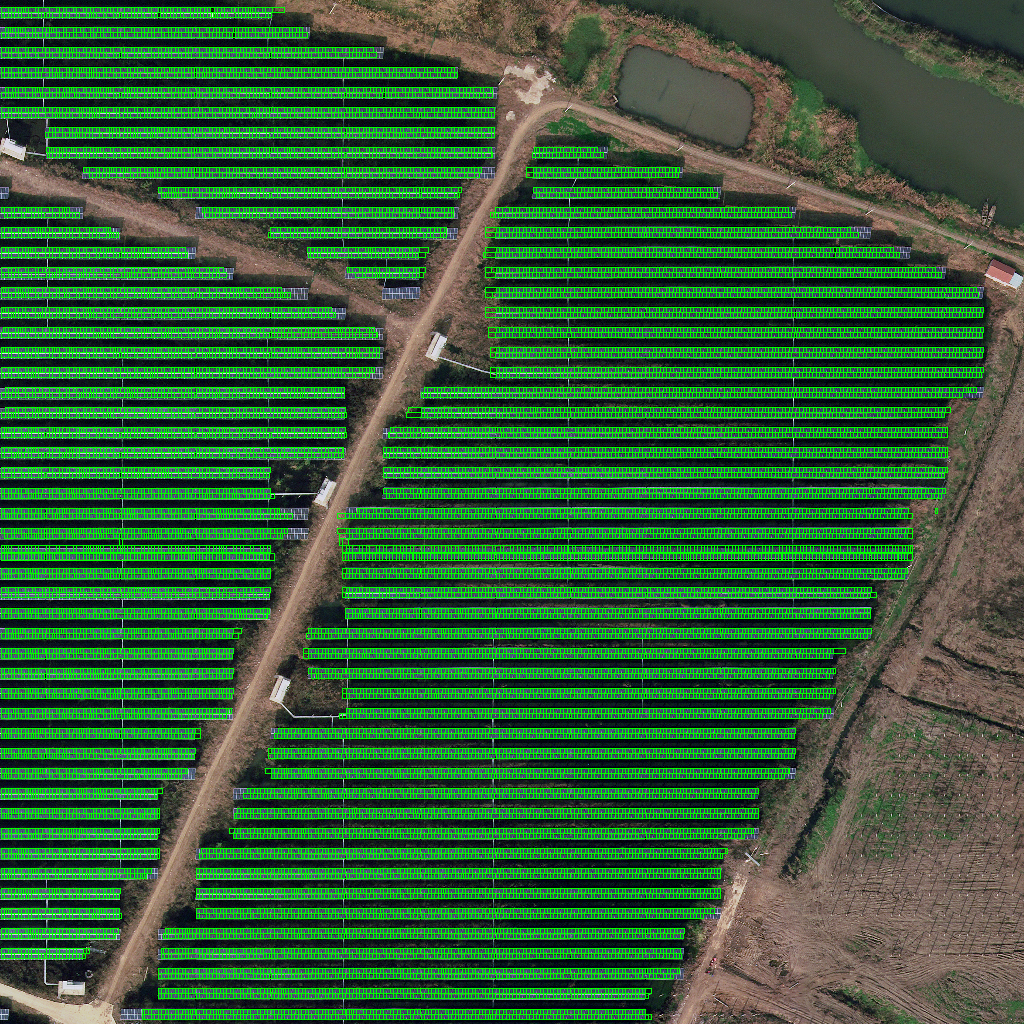

In [53]:
# get original image path
dirPath = "/content/dataset/testing/images" # WHEN WORKING WITH CROPPED VERSION, JUST CHANGE THIS PATH (and also use just one mask)
imgPaths = sorted([os.path.join(dirPath, f) for f in os.listdir(dirPath)])  # dir for all file paths

# load image in original size as numpy array
imgId = 0
img = load_img(imgPaths[imgId])
img = img_to_array(img)

# get image size mask
mask = processMask(img, imgId)
# mask out background
maskedImg = maskBackground(img, mask)
# get edges
edgesH = horizontalEdges(maskedImg)
edgesV = verticalEdges(maskedImg)
# get stripes
stripes = getHorizontalStripes(img, edgesH)
# classify stripes
classifiedStripes = classifyStripes(stripes, edgesV)
# join consecutive panel stripes
joinedStripes = joinStripes(classifiedStripes)
# split panel stripes in half
splittedStripes = splitStripes(joinedStripes)
# detect individual panels
panels = detectPanels(splittedStripes, edgesV)


# draw detected panels
output = img.copy()
for panel in panels:
  cv2.rectangle(output, (panel[0], panel[1]), (panel[0]+panel[2], panel[1]+panel[3]), (0, 255, 0), 1)
cv2_imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))


### Calculate median of panel dimensions

In [54]:
def medianDimensions(panels):
  # calculate the median of panel height
  temp = [panel[2] for panel in panels]

  # check for empty array
  if len(temp) == 0:
    temp = [0]

  medHeight = int(np.median(temp))

  # calculate the median of panel width
  temp2 = [panel[3] for panel in panels]

  # check for empty array
  if len(temp2) == 0:
    temp2 = [0]

  medWidth = int(np.median(temp2))

  # return new values
  return [medWidth, medHeight]

print(medianDimensions(panels))



[5, 3]


### Calculate, how many percent of panels have the correct dimensions (are classified correctly)

In [55]:
allPanels = 0
correctPanels = 0

for i in range(len(imgPaths)):
  # loading the image
  img = load_img(imgPaths[i])
  img = img_to_array(img)

  # get image size mask
  mask = processMask(img, i)
  # mask out background
  maskedImg = maskBackground(img, mask)
  # get edges
  edgesH = horizontalEdges(maskedImg)
  edgesV = verticalEdges(maskedImg)
  # get stripes
  stripes = getHorizontalStripes(img, edgesH)
  # classify stripes
  classifiedStripes = classifyStripes(stripes, edgesV)
  # join consecutive panel stripes
  joinedStripes = joinStripes(classifiedStripes)
  # split panel stripes in half
  splittedStripes = splitStripes(joinedStripes)
  # detect individual panels
  panels = detectPanels(splittedStripes, edgesV)

  # EVALUATION
  # get median dimensions
  medDimensions = medianDimensions(panels)

  # calculate how many panels have correct dimensions (+-2)
  for p in panels:
    if abs(p[2] - medDimensions[0]) <= 2 and abs(p[3] - medDimensions[1]) <= 2:
      correctPanels+=1
    allPanels+=1



print(f"All detected panels: {allPanels}, correct detected panels: {correctPanels}\n")
print(f"Percentage of panels with the correct dimensions: {(correctPanels/allPanels)*100}")

All detected panels: 244560, correct detected panels: 159441

Percentage of panels with the correct dimensions: 65.19504416094209


Final conclusion for image processing: This process should work better on images with more correct mask. Only some minor tweaks should be added there for the image processing part to work better. Also some parameters could be tuned for the program to produce better results.